## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [699]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import skew, mode
from scipy.stats import chi2_contingency
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


sns.set(rc={'figure.figsize':(20, 12)}, style="whitegrid")
%matplotlib inline

### Загружаем данные:

In [700]:
groups_df       = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/DATA/Проект_2_groups.csv', sep=';')
groups_add_df   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/DATA/Проект_2_group_add.csv', sep=',')
active_studs_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/DATA/Проект_2_active_studs.csv')
checks_df       = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/DATA/Проект_2_checks.csv', sep=';')

Загрузка данных через API с помощью функции (использовать, если нет ошибки):

In [701]:
#Создадим переменные с ссылками на данные
url_groups_df       = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_groups_add_df   = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
url_active_studs_df = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
url_checks_df       = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [702]:
#С помощью функции получим загрузочную ссылку
def url_download_ya_disk(public_key):
    base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    final_url    = base_url + urlencode(dict(public_key=public_key)) 
    response     = requests.get(final_url) 
    download_url = response.json()['href']

    return download_url

In [703]:
groups_df_api       = pd.read_csv(url_download_ya_disk(url_groups_df))
groups_add_df_api   = pd.read_csv(url_download_ya_disk(url_groups_add_df))
active_studs_df_api = pd.read_csv(url_download_ya_disk(url_active_studs_df))
checks_df_api       = pd.read_csv(url_download_ya_disk(url_checks_df))

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

*Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.*

Рассмотрим каждый датафрейм и проверим содержание каждого файла.

In [704]:
groups_df.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [705]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [706]:
groups_df.isnull().sum()

id     0
grp    0
dtype: int64

In [707]:
groups_add_df.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [708]:
groups_add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [709]:
groups_add_df.isnull().sum()

id     0
grp    0
dtype: int64

In [710]:
active_studs_df.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [711]:
active_studs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [712]:
active_studs_df.isnull().sum()

student_id    0
dtype: int64

In [713]:
checks_df.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [714]:
checks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [715]:
checks_df.isnull().sum()

student_id    0
rev           0
dtype: int64

Соединим датафреймы с информацией о принадлежности пользователя к контрольной или экспериментальной группе и файлом с дополнительной информацией спустя 2 дня.

In [716]:
groups = pd.merge(groups_df, groups_add_df, how='outer')
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Проверим, есть ли дубликаты в данных.

In [717]:
groups.nunique()

id     74576
grp        2
dtype: int64

Все `id` пользователей уникальны.

In [718]:
group_A = groups.query('grp == "A"')
group_A

,id,grp
1,1627,A
4,1794,A
7,2067,A
8,2078,A
11,2213,A
...,...,...
74558,5870856,A
74560,5921522,A
74567,200247808,A
74568,200247809,A


In [719]:
group_B = groups.query('grp == "B"')
group_B

,id,grp
0,1489,B
2,1768,B
3,1783,B
5,1803,B
6,1805,B
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [720]:
print('Общее количество участников эксперимента:', groups.shape[0])
print('Количество участников группы А (контрольной):', group_A.shape[0])
print('Количество участников группы В (целевой):', group_B.shape[0])

Общее количество участников эксперимента: 74576
Количество участников группы А (контрольной): 14693
Количество участников группы В (целевой): 59883


In [721]:
print('Доля контрольной группы к целевой:', (group_A.shape[0]/group_B.shape[0])*100)

Доля контрольной группы к целевой: 24.536178882153532


#### Рассмотрим различные выборки, которые распределены по признаку действий пользователей:
1. Активные учатники эксперимента
2. Оплатившие участники эксперимента
3. Не активные участники эксперимента, но оплатившие
4. Активные участники эксперимента, но не оплатившие
5. Активные и оплатившие участники эксперимента

1. Проверим информацию о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [722]:
active_groups = groups.query('id in @active_studs_df.student_id')
active_groups.head()

,id,grp
1,1627,A
10,2085,B
12,2215,B
43,3391,A
45,3401,B


In [723]:
all_students = active_groups.merge(checks_df_1, how='outer')
all_students = all_students.dropna(subset=['grp']).fillna(0)
all_students

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0
...,...,...,...
8336,5760471,B,0.0
8337,5777081,B,0.0
8338,5870856,A,0.0
8339,5945085,B,0.0


In [724]:
all_students.groupby('grp', as_index=False).agg({'id':'count', 'rev': 'sum'})

,grp,id,rev
0,A,1538,72820.0000
1,B,6803,394974.0035


In [725]:
active_group_A = active_groups.query('grp == "A"')
active_group_A.head()

,id,grp
1,1627,A
43,3391,A
331,109623,A
614,133678,A
1002,175944,A


In [726]:
active_group_B = active_groups.query('grp == "B"')
active_group_B.head()

,id,grp
10,2085,B
12,2215,B
45,3401,B
112,22994,B
159,26899,B


In [727]:
print('Общее количество активных участников эксперимента:', active_groups.shape[0])
print('Количество активных участников группы А (контрольной):', active_group_A.shape[0])
print('Количество активных участников группы В (целевой):', active_group_B.shape[0])

Общее количество активных участников эксперимента: 8341
Количество активных участников группы А (контрольной): 1538
Количество активных участников группы В (целевой): 6803


In [728]:
#Рассмотрим процентное соотношение двух групп, которые были активны.
active_students_total = active_groups.groupby('grp', as_index=False)\
                                     .agg({'id': 'count'})\
                                     .rename(columns={'id': "count_id"})
active_students_total['percentage'] = (active_students_total.count_id / active_groups.shape[0] * 100).round(0)
active_students_total

,grp,count_id,percentage
0,A,1538,18.0
1,B,6803,82.0


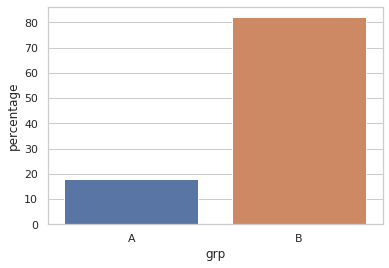

In [729]:
ax = sns.barplot(x='grp', y='percentage', data = active_students_total)

2. Проверим информацию о тех пользователях, которые произвели оплату в дни проведения эксперимента.

In [730]:
checks_groups = groups.query('id in @checks_df.student_id')
checks_groups.head()

,id,grp
1,1627,A
39,3185,B
121,25973,B
125,26280,B
220,100300,B


In [731]:
checks_group_A = checks_groups.query('grp == "A"')
checks_group_A.head()

,id,grp
1,1627,A
406,114366,A
2041,212994,A
2231,218393,A
2393,225541,A


In [732]:
checks_group_B = checks_groups.query('grp == "B"')
checks_group_B.head()

,id,grp
39,3185,B
121,25973,B
125,26280,B
220,100300,B
223,100645,B


In [733]:
print('Общее количество оплативших участников эксперимента:', checks_groups.shape[0])
print('Количество оплативших участников группы А (контрольной):', checks_group_A.shape[0])
print('Количество оплативших участников группы В (целевой):', checks_group_B.shape[0])

Общее количество оплативших участников эксперимента: 541
Количество оплативших участников группы А (контрольной): 107
Количество оплативших участников группы В (целевой): 434


In [734]:
#Рассмотрим процентное соотношение двух групп, которые произвели оплату.
checks_students_total = checks_groups.groupby('grp', as_index=False)\
                                     .agg({'id': 'count'})\
                                     .rename(columns={'id': "count_id"})
checks_students_total['percentage'] = (checks_students_total.count_id / checks_groups.shape[0] * 100).round(0)
checks_students_total

,grp,count_id,percentage
0,A,107,20.0
1,B,434,80.0


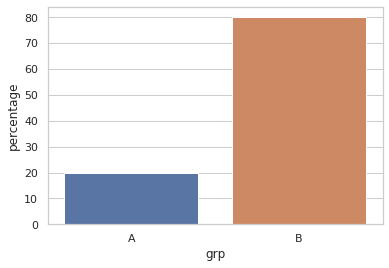

In [735]:
ax = sns.barplot(x='grp', y='percentage', data = checks_students_total)

Рассмотрим распределение суммы оплаты среди пользователей в общем и по группам.

In [736]:
checks_df_1 = checks_df.rename(columns={'student_id':'id'})

In [737]:
checks_groups_revenue = pd.merge(checks_df_1, checks_groups, how='inner')
checks_groups_revenue

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B
...,...,...,...
536,5645737,1900.0,B
537,5651566,1900.0,B
538,5662322,1900.0,B
539,5681918,1900.0,B


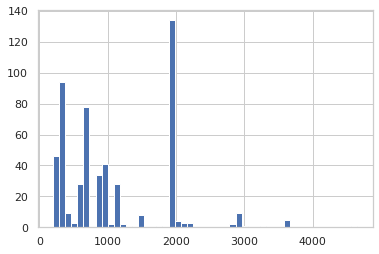

In [738]:
#Общее распределение
checks_groups_revenue.rev.hist(bins=50)

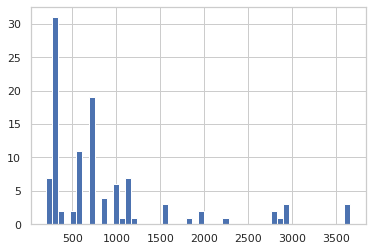

In [739]:
#Распределение в группе А
checks_groups_revenue_A = checks_groups_revenue.query('grp == "A"')
checks_groups_revenue_A.rev.hist(bins=50)

In [740]:
checks_groups_revenue_A.agg({'rev': 'mode'})

,rev
0,290.0


In [741]:
#Распределение по количеству частых сумм платежей в группе A
checks_groups_revenue_A.groupby('rev', as_index=False) \
                       .agg({'id': 'count'}) \
                       .rename(columns={'id':'count_id'})\
                       .sort_values('count_id', ascending=False)\
                       .head(5)

,rev,count_id
1,290.0,31
6,690.0,19
0,199.0,7
9,990.0,6
4,580.0,6


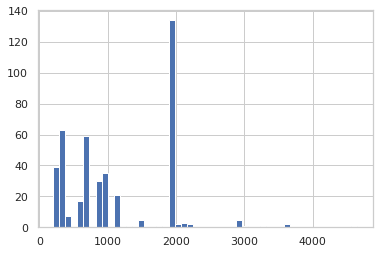

In [742]:
#Распределение в группе B
checks_groups_revenue_B = checks_groups_revenue.query('grp == "B"')
checks_groups_revenue_B.rev.hist(bins=50)

In [743]:
checks_groups_revenue_B.agg({'rev': 'mode'})

,rev
0,1900.0


In [744]:
#Распределение по количеству частых сумм платежей в группе B
checks_groups_revenue_B.groupby('rev', as_index=False) \
                       .agg({'id': 'count'}) \
                       .rename(columns={'id':'count_id'})\
                       .sort_values('count_id', ascending=False)\
                       .head(5)

,rev,count_id
22,1900.0000,97
1,290.0000,63
8,690.0000,59
0,199.0000,39
23,1900.0001,36


`Исходя из графиков можем заметить, что в распределении в группе B наиболее частая сумма оплаты была больше (1900), чем в группе А (290), а также количество произведённых оплат больше в группе B (97) с суммой 1900, чем в группе A (31) с суммой 290.`

3. Проверим данные на то, есть ли среди них участники, которые могли оплатить услуги на сайте, но не быть активными.

In [745]:
not_active_paid = checks_df.query('student_id not in @active_studs_df.student_id')
not_active_paid.head()

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0


In [746]:
print('Общее количество оплативших участников, но не активных:', not_active_paid.shape[0])

Общее количество оплативших участников, но не активных: 149


Рассмотрим количество таких участников по каждой группе.

In [747]:
not_active_paids = groups.query('id in @not_active_paid.student_id')
not_active_paids.head()

,id,grp
39,3185,B
121,25973,B
125,26280,B
223,100645,B
254,102534,B


In [748]:
not_active_paid_A = group_A.query('id in @not_active_paid.student_id')
not_active_paid_A.head()

,id,grp
406,114366,A
2041,212994,A
2231,218393,A
2393,225541,A
2969,243614,A


In [749]:
not_active_paid_B = group_B.query('id in @not_active_paid.student_id')
not_active_paid_B.head()

,id,grp
39,3185,B
121,25973,B
125,26280,B
223,100645,B
254,102534,B


In [750]:
print('Общее количество оплативших участников, но не активных:', not_active_paid.shape[0])
print('Количество оплативших участников, но не активных группы А (контрольной):', not_active_paid_A.shape[0])
print('Количество оплативших участников, но не активных группы B (целевой):', not_active_paid_B.shape[0])

Общее количество оплативших участников, но не активных: 149
Количество оплативших участников, но не активных группы А (контрольной): 29
Количество оплативших участников, но не активных группы B (целевой): 120


In [751]:
#Рассмотрим процентное соотношение двух групп, которые произвели оплату, но не были активны.
not_active_paid_total = not_active_paids.groupby('grp', as_index=False)\
                                        .agg({'id': 'count'})\
                                        .rename(columns={'id': "count_id"})
not_active_paid_total['percentage'] = (not_active_paid_total.count_id / not_active_paids.shape[0] * 100).round(0)
not_active_paid_total

,grp,count_id,percentage
0,A,29,19.0
1,B,120,81.0


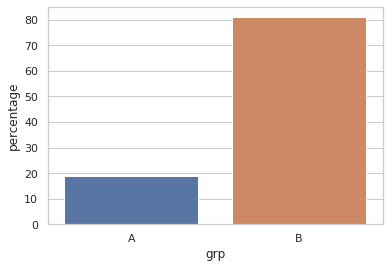

In [752]:
ax = sns.barplot(x='grp', y='percentage', data = not_active_paid_total)

4. Проверим данные на то, есть ли среди них участники, которые не оплатили услуги на сайте, но были активными.

In [753]:
not_paid_active = active_studs_df.query('student_id not in @checks_df.student_id and student_id in @active_studs_df.student_id')
not_paid_active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [754]:
print('Общее количество активных участников, но не оплативших:', not_paid_active.shape[0])

Общее количество активных участников, но не оплативших: 7949


Рассмотрим количество таких участников по каждой группе.

In [755]:
not_paid_actives = groups.query('id in @not_paid_active.student_id')
not_paid_actives.head()

,id,grp
10,2085,B
12,2215,B
43,3391,A
45,3401,B
112,22994,B


In [756]:
not_paid_active_A = group_A.query('id in @not_paid_active.student_id')
not_paid_active_A.head()

,id,grp
43,3391,A
331,109623,A
614,133678,A
1002,175944,A
1101,179400,A


In [757]:
not_paid_active_B = group_B.query('id in @not_paid_active.student_id')
not_paid_active_B.head()

,id,grp
10,2085,B
12,2215,B
45,3401,B
112,22994,B
159,26899,B


In [758]:
print('Общее количество активных участников, но не оплативших:', not_paid_active.shape[0])
print('Количество активных участников, но не оплативших группы А (контрольной):', not_paid_active_A.shape[0])
print('Количество активных участников, но не оплативших группы B (целевой):', not_paid_active_B.shape[0])

Общее количество активных участников, но не оплативших: 7949
Количество активных участников, но не оплативших группы А (контрольной): 1460
Количество активных участников, но не оплативших группы B (целевой): 6489


In [759]:
#Рассмотрим процентное соотношение двух групп, которые были активны, но не произвели оплату.
not_active_paid_total = not_paid_actives.groupby('grp', as_index=False)\
                                        .agg({'id': 'count'})\
                                        .rename(columns={'id': "count_id"})
not_active_paid_total['percentage'] = (not_active_paid_total.count_id / not_paid_actives.shape[0] * 100).round(0)
not_active_paid_total

,grp,count_id,percentage
0,A,1460,18.0
1,B,6489,82.0


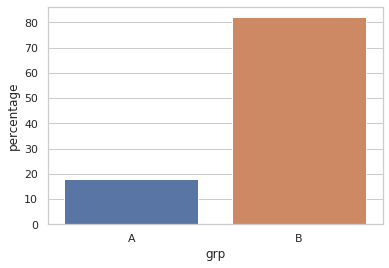

In [760]:
ax = sns.barplot(x='grp', y='percentage', data = not_active_paid_total)

5. Проверим количество активных оплативших участников.

In [761]:
active_students = checks_df.query('student_id in @active_studs_df.student_id')
active_students

,student_id,rev
0,1627,990.0000
4,100300,990.0000
8,108270,290.0000
26,264473,1900.0001
27,274352,690.0000
...,...,...
536,5645737,1900.0000
537,5651566,1900.0000
538,5662322,1900.0000
539,5681918,1900.0000


In [762]:
print('Общее количество активных оплативших участников:', active_students.shape[0])

Общее количество активных оплативших участников: 392


In [763]:
active_students_groups = groups.query('id in @active_students.student_id')
active_students_groups.head()

,id,grp
1,1627,A
220,100300,B
320,108270,B
3779,264473,B
4187,274352,B


In [764]:
active_students_A = group_A.query('id in @active_students.student_id')
active_students_A.head()

,id,grp
1,1627,A
4625,287008,A
6328,332387,A
7071,347455,A
9916,445767,A


In [765]:
active_students_B = group_B.query('id in @active_students.student_id')
active_students_B.head()

,id,grp
220,100300,B
320,108270,B
3779,264473,B
4187,274352,B
4399,280036,B


In [766]:
print('Общее количество активных оплативших участников:', active_students.shape[0])
print('Количество активных оплативших участников группы А (контрольной):', active_students_A.shape[0])
print('Количество активных оплативших участников группы B (целевой):', active_students_B.shape[0])

Общее количество активных оплативших участников: 392
Количество активных оплативших участников группы А (контрольной): 78
Количество активных оплативших участников группы B (целевой): 314


In [767]:
#Рассмотрим процентное соотношение двух групп, которые были активны и произвели оплату.
active_students_groups_total = active_students_groups.groupby('grp', as_index=False)\
                                        .agg({'id': 'count'})\
                                        .rename(columns={'id': "count_id"})
active_students_groups_total['percentage'] = (active_students_groups_total.count_id / active_students_groups.shape[0] * 100).round(0)
active_students_groups_total

,grp,count_id,percentage
0,A,78,20.0
1,B,314,80.0


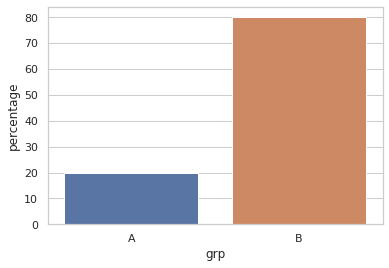

In [768]:
ax = sns.barplot(x='grp', y='percentage', data = active_students_groups_total)

Исходя из анализа 5 выборок по функциональному признаку (действий на сайте), можем сделать вывод, что всего оплативших пользователей 541 пользоваталь (А - 107, В - 434), а количество участников оплативших и неактивных составляет 149, то есть, возможно, был произведён автоплатёж, либо оплата иным способом без входа на сайт. Данный сегмент участников не будем рассматривать, поскольку они не взаимодействовали с новой механикой на сайте оплаты услуг.

Таким образом, будем рассматривать кагорту активных и оплативших: 392 участника (А - 78, В - 314). 

In [769]:
active_students_revenue = pd.merge(checks_df_1, active_students_groups, how='inner')
active_students_revenue

,id,rev,grp
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B
...,...,...,...
387,5645737,1900.0000,B
388,5651566,1900.0000,B
389,5662322,1900.0000,B
390,5681918,1900.0000,B


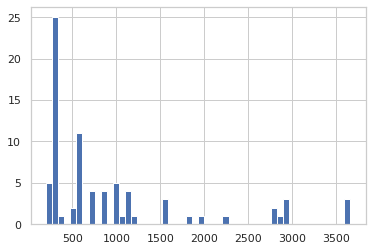

In [770]:
#Распределение в группе А
active_students_revenue_A = active_students_revenue.query('grp == "A"')
active_students_revenue_A.rev.hist(bins=50)

In [771]:
active_students_revenue_A.agg({'rev': 'mode'})

,rev
0,290.0


In [772]:
#Распределение по количеству частых сумм платежей в группе B
active_students_revenue_A.groupby('rev', as_index=False) \
                       .agg({'id': 'count'}) \
                       .rename(columns={'id':'count_id'})\
                       .sort_values('count_id', ascending=False)\
                       .head(5)

,rev,count_id
1,290.0,25
4,580.0,6
0,199.0,5
9,990.0,5
5,590.0,5


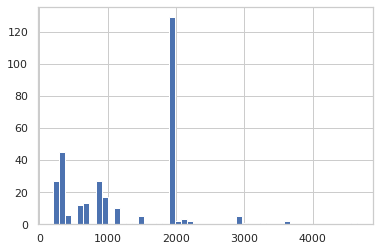

In [773]:
#Распределение в группе B
active_students_revenue_B = active_students_revenue.query('grp == "B"')
active_students_revenue_B.rev.hist(bins=50)

In [774]:
active_students_revenue_B.agg({'rev': 'mode'})

,rev
0,1900.0


In [775]:
#Распределение по количеству частых сумм платежей в группе B
active_students_revenue_B.groupby('rev', as_index=False) \
                       .agg({'id': 'count'}) \
                       .rename(columns={'id':'count_id'})\
                       .sort_values('count_id', ascending=False)\
                       .head(5)

,rev,count_id
20,1900.0000,93
1,290.0000,45
21,1900.0001,35
0,199.0000,27
9,840.0000,21


`Исходя из представленных графиков наблюдается аналогичная тенденция, что в распределении в группе B наиболее частая сумма оплаты была больше (1900), чем в группе А (290), а также количество произведённых оплат больше в группе B (93) с суммой 1900, чем в группе A (25) с суммой 290.`

Для наглядности рассмотрим в общей диаграмме распределение суммы оплаты двух групп:

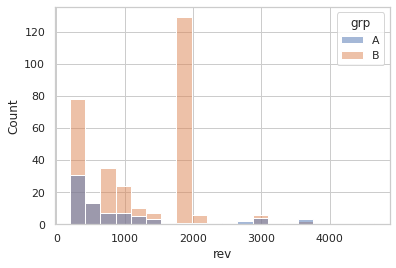

In [776]:
sns.histplot(data=active_students_revenue, x='rev', hue='grp', bins=20)

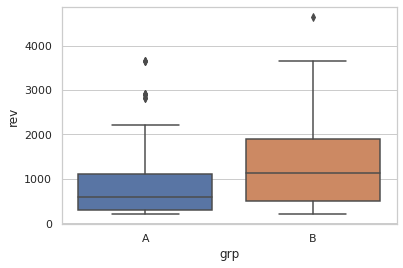

In [777]:
sns.boxplot(data = active_students_revenue, x = 'grp', y = 'rev')

По диаграмме "ящик с усами" можем сказать, что медиана группы В выше, чем в группе А, однако, медиана группы А входит в доверительный интервал сравниваемой группы, предполагается, что статистически значимых разичий нет, но требуется проверка. Нижние границы двух групп одинаковы, а верхняя граница и верхний квартиль группы В выше, чем в группе А, что говорит о вхождении в группу больших сумм оплаты в нашем случае. Присутствуют и выбросы в каждой подгруппе. 

Рассмотрим описательную статистику каждой группы:

In [778]:
active_students_describe_A = active_students_revenue_A.rev.to_frame().describe().rename(columns={'rev':'Группа A'})
active_students_describe_B = active_students_revenue_B.rev.to_frame().describe().rename(columns={'rev':'Группа B'})
pd.concat([active_students_describe_A, active_students_describe_B], axis=1)

,Группа A,Группа B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


Изучив данные релевантной выборки, можем сделать некоторые выводы:
1. Количество участников двух групп (объём выборки) сильно разнится: 20% участников от общего количества в группе А и 80% участников в группе В. Для точной статистической оценки необходимо распределение групп 50% на 50%.
2. Стандартное отклонение в группе В в отличие от группы уменьшилось, что говорит о том, что разброс значений уменьшился.
3. Количество пользователей, которые произвели оплату в целевой группе увеличлось на 402% в сравнении с тестовой группой.

#### Опеределим ключевые метрики для определения статистической значимости показателей:
Поскольку нам необходимо оценить, правда ли, что новый алгоритм улучшил качество сервиса. Будем использовать:
- `CR` — коэффициент конверсии (= число посетителей, совершивших целевое действие / Общее кол-во посетителей),
- `ARPU` — доход от пользователя (= доход за определённый период / количество пользователей, которые купили товар за это время), 
- `ARPPU` — доход от платной подписки (= доход за период / число платных подписок за это время), 

Произведём рассчёты каждой метрики и проверим наши гипотезы с помощью статистического теста.

#### Первая метрика - CR

In [779]:
CR_A = round(active_students_revenue_A.shape[0]/active_group_A.shape[0],3)
CR_B = round(active_students_revenue_B.shape[0]/active_group_B.shape[0],3)

In [780]:
print('Коэффициент конверсии в группе А:', CR_A)
print('Коэффициент конверсии в группе В:', CR_B)
print('Изменение конверсии после введения новой механики оплаты услуг:', - round((CR_B/CR_A)*100-100, 3))

Коэффициент конверсии в группе А: 0.051
Коэффициент конверсии в группе В: 0.046
Изменение конверсии после введения новой механики оплаты услуг: 9.804


Коэффициент конверсии в группе В по сравнению с группой А уменьшился на 9,8%. Следовательно, число пользователей, совершивших оплату уменьшилось в целевой группе.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


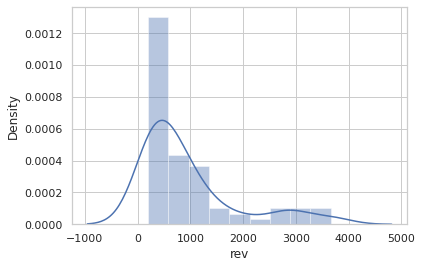

In [781]:
sns.distplot(active_students_revenue_A.rev)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


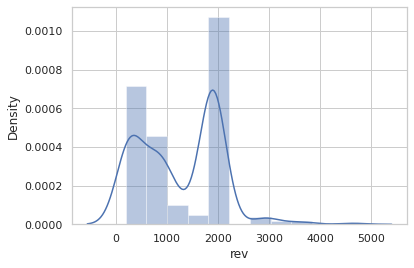

In [782]:
sns.distplot(active_students_revenue_B.rev)

Распределение оплат среди студентов распределено ненормально, что видно из графиков.

#### Вторая метрика - ARPU

In [783]:
ARPU_A = round(active_students_revenue_A.rev.sum()/active_group_A.shape[0],3)
ARPU_B = round(active_students_revenue_B.rev.sum()/active_group_B.shape[0],3)

In [784]:
print('Доход на одного пользователя в группе А:', ARPU_A)
print('Доход на одного пользователя в группе В:', ARPU_B)
print('Изменение дохода на одного пользователя после введения новой механики оплаты услуг: +', round((ARPU_B/ARPU_A)*100-100, 3))

Доход на одного пользователя в группе А: 47.347
Доход на одного пользователя в группе В: 58.059
Изменение дохода на одного пользователя после введения новой механики оплаты услуг: + 22.624


Доход на одного пользователя увеличился в целевой группе по отношению к тестовой на 22,6%. Следовательно, доходность пользователей повысилась.

#### Третья метрика - ARPPU

In [785]:
ARPPU_A = round(active_students_revenue_A.rev.sum()/active_students_A.shape[0],3)
ARPPU_B = round(active_students_revenue_B.rev.sum()/active_students_B.shape[0],3)

In [786]:
print('Доход от платной подписки (платящего пользователя) в группе А:', ARPPU_A)
print('Доход от платной подписки (платящего пользователя) в группе В:', ARPPU_B)
print('Изменение дохода от платной подписки на одного пользователя после введения новой механики оплаты услуг: +', round((ARPPU_B/ARPPU_A)*100-100, 3))

Доход от платной подписки (платящего пользователя) в группе А: 933.59
Доход от платной подписки (платящего пользователя) в группе В: 1257.879
Изменение дохода от платной подписки на одного пользователя после введения новой механики оплаты услуг: + 34.736


Доход от платной подписки увеличился в целевой группе по отношению к тестовой на 34,736%. Следовательно, доходность платной подписки повысилась.

Проверим нормальность распределения данных, а также проверим, насколько эффективна и адекватна статистическая оценка модели. Кроме того, исходя из рассчитанных метрик сформулируем и проверим гипотезы о влиянии новой механики оплаты на сайте на метрики.  

Рассмотрим однородность двух выборок, сравнив между собой, воспользуемся t-критерием Стьюдента.

Гипотезы:
- $H_0$: распределение в выборках нормально
- $H_1$: распределение в выборках не нормально

In [787]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

Применяя Т-критерий Стьюдента нужно помнить о следующем:

Дисперсии должны быть приблизительно равны (проверим с помощью критерия Левена)

In [788]:
ss.levene(active_students_revenue_A.rev, active_students_revenue_B.rev, center='median')

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

In [789]:
ss.levene(active_students_revenue_A.rev, active_students_revenue_B.rev, center='mean')

LeveneResult(statistic=0.35109219559848354, pvalue=0.5538389015879754)

In [790]:
pg.normality(data=active_students_revenue, dv="rev", 
                   group="grp", method="normaltest")

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


В обоих методах p-значение различное, где центром является медиана p-value составляет более 0,05, а также при среднем - более 0,05. Это означает, что в во всех случаях мы отвергаем нулевую гипотезу.

2. Требование к нормальности.

In [791]:
ttest_ind(active_students_revenue_A.rev, active_students_revenue_B.rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

**Вывод**:
Доверительные интервалы не пересекаются , это значит, что средние значения в генеральных совокупностях не одинаковы.

В этом случае гипотеза о совпадении средних в генеральных совокупностях отклоняется, принимается альтернативная гипотеза о неравности, а различие между выборочными средними считается статистически незначимым (несущественным).

##### Проверим взаимосвязь каждой метрики с новой механикой оплаты на сайте.

#### Первая метрика - CR

Гипотезы:
- $H_0$: Отличий между конверсими в покупку между тестовой и контрольной группами нет.
- $H_1$: Отличия между конверсими в покупку между тестовой и контрольной группами существуют.

Воспользуемся методом Хи-квадрат для категориальных переменных 
(в нашем случае 0 - нет оплаты, rev>0 - оплата есть)

In [792]:
active_group_A_payed = active_groups_rev.query('rev > 0 and grp == "A"').shape[0]
active_group_A_npayed = active_groups_rev.query('grp == "A"').shape[0] - active_group_A_payed

In [793]:
active_group_B_payed = active_groups_rev.query('rev > 0 and grp == "B"').shape[0]
active_group_B_npayed = active_groups_rev.query('grp == "B"').shape[0] - active_group_B_payed

In [794]:
# Выполнение Хи-квадрат теста
data = np.array([[active_group_A_payed, active_group_A_npayed], 
                 [active_group_B_payed, active_group_B_npayed]])

chi2, p_value, dof, expected = ss.chi2_contingency(data, correction = False)

print("Статистика Хи-квадрат:", chi2)
print("p-value:", p_value)
print("Ожидаемые частоты:", expected)
print("Степени свободы:", dof)

Статистика Хи-квадрат: 0.5821513741106591
p-value: 0.44547028437158964
Ожидаемые частоты: [[  72.28102146 1465.71897854]
 [ 319.71897854 6483.28102146]]
Степени свободы: 1


In [795]:
prob = 0.95
alpha = 1.0 - prob
if p_value <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


**Вывод**: Поскольку p-value меньше 0,5, то мы не отклоняем нулевую гипотезу. Следовательно, отличий между конверсими в покупку между тестовой и контрольной группами нет, новая механика оплаты услуг на сайте не влияет на снижение конверсии.

#### Вторая метрика - ARPU 

Гипотезы:
- $H_0$: Отличий между доходом на одного пользователя между тестовой и контрольной группами нет.
- $H_1$: Отличия между доходом на одного пользователя между тестовой и контрольной группами существуют.

Можем воспользоваться критерием Манна-Уитни, поскольку у нас есть количественная переменная `rev` и категориальная `grp`. Кроме того, распределение является ненормальным, что было подтверждено выше. Однако, велика вероятность ошибиться при применении данного теста в нашем случае, поэтому воспользуемся **методом бутстрап**, который более точен и работает с большими выбросами в данных.

In [828]:
active_group_A_ARPU = all_students.query('grp == "A"')
active_group_B_ARPU = all_students.query('grp == "B"')

In [829]:
active_group_A_ARPU

,id,grp,rev
0,1627,A,990.0
3,3391,A,0.0
13,109623,A,0.0
15,133678,A,0.0
23,175944,A,0.0
...,...,...,...
8319,5668989,A,0.0
8327,5690284,A,0.0
8329,5723133,A,0.0
8332,5729371,A,0.0


In [831]:
def arpu_func(y):
    return np.median(x)

Напишем функцию бутстрап:

In [832]:
def get_bootstrap(
    data_column_1,              # контрольная (А) выборка
    data_column_2,              # целевая (В) выборка
    col_1,                      # столбец выборки А
    col_2,                      # столбец выборки Б
    sample_count_1=0,           # количество наблюдений для подвыборок
    sample_count_2=0,           # количество наблюдений для подвыборок
    
    boot_it = 10000,              # количество бутстрап-подвыборок
    statistic = np.median,        # статистика, которую будем рассматривать
    bootstrap_conf_level = 0.95,  # уровень значимости
    replace = True,               # параметр возвращения
    max_len = True,
    graph   = True                # график
):
    from scipy.stats import norm
    from tqdm.auto import tqdm  #индикатор прогресса

    if sample_count_1 == 0:
        sample_count_1 = len(data_column_1[col_1])

    if sample_count_2 == 0:
        sample_count_2 = len(data_column_1[col_2])
    
    if max_len:
        boot_len = max([sample_count_1, sample_count_2])
    else:
        boot_len = min([sample_count_1, sample_count_2])

    boot_data   = []
    smpl_1_data = []
    smpl_2_data = []
    
    for i in tqdm(range(boot_it)):      #извлекаем подвыборки
        if statistic == 'arpu':
            samples_1 = arpu(data_column_1.sample(boot_len, replace=replace))
            samples_2 = arpu(data_column_2.sample(boot_len, replace=replace))
        else:
            samples_1 = np.nanmean(data_column_1[col_1].sample(boot_len, replace=replace).values)
            samples_2 = np.nanmean(data_column_2[col_2].sample(boot_len, replace=replace).values)

 
        boot_data.append(samples_2-samples_1) # находим разницу подвыборок
        smpl_1_data.append(samples_1)
        smpl_2_data.append(samples_2)

    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quantiles = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    #визуализация данных
    if graph == True:
        sns.set(font_scale=1.2, style="whitegrid", rc={'figure.figsize': (8, 5)})
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(quantiles, ymin=0, ymax=700, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of bootstrap")
        plt.show()

    print('p-value = ', p_value, 'quantiles = ', quantiles)
 
    return {"boot_data"   : boot_data, 
            "quantiles"   : quantiles,
            "p_value"     : p_value,
            "smpl_1_data" : smpl_1_data,
            "smpl_2_data" : smpl_2_data}

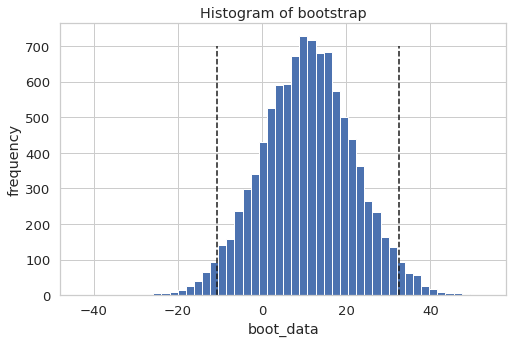

p-value =  0.32188203303730034 quantiles =                 0
0.025 -10.608680
0.975  32.573911


In [833]:
arpu_bootstrap = get_bootstrap(data_column_1=active_group_A_ARPU, col_1='rev',
                               data_column_2=active_group_B_ARPU, col_2='rev',
                               boot_it=10000,
                               statistic='arpu_func')

**Вывод**: Поскольку p-value меньше 0,5, а 0 попадает в доверительный интервал, то мы не можем отклонить нулевую гипотезу. Следовательно, отличия между доходность от одного пользователя между тестовой и контрольной группами значимо не отличаются, новая механика оплаты услуг на сайте может не влиять на доходность одного пользователя.

#### Третья метрика - ARPPU

Гипотезы:
- $H_0$: Отличий между доходом от платной подписки между тестовой и контрольной группами нет.
- $H_1$: Отличия между доходом от платной подписки между тестовой и контрольной группами существуют.

Воспользуемся аналогично методом бутстрап.

In [501]:
active_groups_ARPPU = round(active_students_revenue.groupby('grp', as_index=False).agg({'id':'count', 'rev':'sum'}),2)
active_groups_ARPPU

,grp,id,rev
0,A,78,72820.0
1,B,314,394974.0


In [503]:
active_groups_ARPPU['ARPPU'] = round(active_groups_ARPPU['rev'] / active_groups_ARPPU['id'], 2) 
active_groups_ARPPU

,grp,id,rev,ARPPU
0,A,78,72820.0,933.59
1,B,314,394974.0,1257.88


In [696]:
active_group_A_ARPPU = active_students_revenue.query('grp == "A" and rev != 0')
active_group_B_ARPPU = active_students_revenue.query('grp == "B" and rev != 0')

In [697]:
def arppu_func(y):
    return np.median(y)

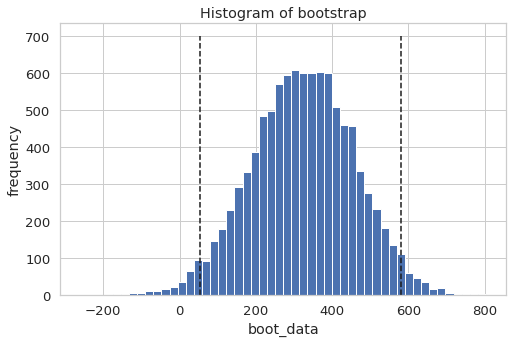

p-value =  0.01664097113394449 quantiles =                  0
0.025   52.598083
0.975  580.488792


In [814]:
arppu_bootstrap = get_bootstrap(data_column_1=active_group_A_ARPPU, col_1='rev',
                                data_column_2=active_group_B_ARPPU, col_2='rev',
                                boot_it=10000,
                                statistic='arppu_func')

**Вывод**: Поскольку p-value меньше 0,5, а 0 не входит в доверительный  интервал, то мы отклоняем нулевую гипотезу. Следовательно, отличия между доходностью от платящего пользователя между тестовой и контрольной группами существует, новая механика оплаты услуг на сайте влияет на доходность одного  платящего пользователя.

Таким образом, исходя из проведённых тестов, новая механика оплаты на сайте оказало положительное влияние на метрики `ARPU` (однако данная метрика не показала статистически значимых различий между группами), `ARPPU`, конверсия в покупку (`CR`) имела отрицательный эффект, однако, является статистически незначимой метрикой, то есть не оказывает влияния на наши выборки.

**Следует распределить данные в подвыборках равномерно для более точной оценки поставленной гипотезы.**

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача
Дана таблица default.peas:
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs и default.final_project_check:

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

#### Решение задачи 2.1

In [81]:
import pandahouse as ph

Подключимся к таблице из Clickhouse с помощью pandahouse

In [82]:
connection_database = {'host': 'https://clickhouse.lab.karpov.courses',
                       'database': 'default',
                       'user': 'student', 
                       'password': 'dpo_python_2020'
                       }

In [83]:
default_peas_df = """
                  SELECT 
                      st_id, 
                      toDateTime(timest) as timest,
                      correct, 
                      subject
                  FROM 
                      default.peas
                  """

In [84]:
default_peas_df = ph.read_clickhouse(query=default_peas_df, connection=connection_database)
default_peas_df.sample(10)

,st_id,timest,correct,subject
1260,234705,2021-10-31 05:17:41,1,Theory of probability
3521,382711,2021-10-31 00:57:58,0,Vizualization
5901,549176,2021-10-30 22:15:02,0,Python
6075,563549,2021-10-31 09:52:34,1,Python
11969,937983,2021-10-31 12:02:01,1,Math
11918,937983,2021-10-30 17:45:28,0,Theory of probability
10553,807473,2021-10-31 12:02:00,1,Python
10945,839280,2021-10-30 17:28:31,1,Math
13241,996911,2021-10-31 09:12:28,0,Statistics
6113,572698,2021-10-30 16:56:05,1,Statistics


Напишем запрос, который выдаст усердных учеников (корректные задания >= 20) за месяц.
Разобьём запрос на несколько частей:
1. Найдём интервал дат, возьмём текущий месяц.
2. Найдём количество усердных учеников, котоыре решили хотя бы 20 и более заданий.

In [85]:
#Рассмотрим диапозон дат
interval_date = """
                SELECT 
                    MIN(toDateTime(timest)) as min_date, 
                    MAX(toDateTime(timest)) as max_date
                FROM default.peas
                """

In [86]:
interval_date = ph.read_clickhouse(query=interval_date, connection=connection_database)
interval_date

,min_date,max_date
0,2021-10-30 13:00:00,2021-10-31 17:29:52


In [87]:
# количество усердных студентов за текущий месяц
count_smart_students = """
                    SELECT 
                        COUNT(DISTINCT(st_id)) as count_student
                    FROM
                    (
                        SELECT 
                            st_id,
                            SUM(correct)
                        FROM default.peas
                        WHERE toMonth(timest) == toMonth(now())
                        GROUP BY st_id
                        HAVING SUM(correct) >= 20
                    )
                    """

In [88]:
# общее количество усердных студентов
count_smart_students_total = """
                    SELECT 
                        COUNT(DISTINCT(st_id)) as count_student
                    FROM
                    (
                        SELECT 
                            st_id,
                            SUM(correct)
                        FROM default.peas
                        GROUP BY st_id
                        HAVING SUM(correct) >= 20
                    )
                    """

In [89]:
count_smart_students = ph.read_clickhouse(query=count_smart_students, connection=connection_database)
count_smart_students

,count_student
0,0


In [90]:
count_smart_students_total = ph.read_clickhouse(query=count_smart_students_total, connection=connection_database)
count_smart_students_total

,count_student
0,136


Количество усердных учеников равно 136 как за текущий месяц (октябрь), так и за всё время.

#### Решение задачи 2.2

In [91]:
default_peas_df = """
                  SELECT 
                      st_id, 
                      toDateTime(timest) as timest,
                      correct, 
                      subject
                  FROM 
                      default.peas
                  """

In [92]:
default_peas_df = ph.read_clickhouse(query=default_peas_df, connection=connection_database)
default_peas_df.sample(10)

,st_id,timest,correct,subject
3853,396497,2021-10-31 07:28:04,0,Statistics
7674,673738,2021-10-31 06:51:01,1,Python
8632,704434,2021-10-31 08:57:01,1,Vizualization
9487,739779,2021-10-31 06:00:31,0,Theory of probability
7078,621890,2021-10-31 04:25:09,1,Math
11871,936163,2021-10-30 20:36:06,0,Vizualization
3681,3910,2021-10-30 16:36:47,0,Vizualization
10895,831736,2021-10-31 10:32:51,0,Statistics
7924,680668,2021-10-30 19:51:59,1,Statistics
4757,4557,2021-10-30 18:00:04,0,Statistics


In [93]:
default_studs = """
                  SELECT 
                      st_id, 
                      test_grp
                  FROM 
                      default.studs
                  """

In [94]:
default_studs = ph.read_clickhouse(query=default_studs, connection=connection_database)
default_studs.sample(10)

,st_id,test_grp
504,85595,control
100,275199,pilot
35,147316,pilot
194,395713,pilot
329,609528,pilot
471,806952,control
5,106010,pilot
173,370846,pilot
488,837725,control
1,101432,control


In [95]:
default_final_project_check = """
                              SELECT 
                                  st_id, 
                                  toDateTime(sale_time) as sale_time,
                                  money,
                                  subject
                              FROM 
                                  default.final_project_check
                              """

In [96]:
default_final_project_check = ph.read_clickhouse(query=default_final_project_check, connection=connection_database)
default_final_project_check.sample(10)

,st_id,sale_time,money,subject
8,230858,2021-10-31 08:14:34,85000,Math
12,270197,2021-10-31 06:13:24,85000,Math
36,689556,2021-10-31 06:19:18,75000,Statistics
42,767538,2021-10-30 23:07:55,85000,Math
41,767538,2021-10-30 20:28:52,75000,Statistics
10,270197,2021-10-30 16:15:04,75000,Statistics
16,370846,2021-10-31 00:33:55,100000,Python
44,770149,2021-10-31 08:18:06,70000,Theory of probability
50,831736,2021-10-31 08:13:57,85000,Math
45,774218,2021-10-30 15:46:33,85000,Math


По данным необходимо рассчитать следующие показатели:
- `ARPU` (= доход за определённый период / количество пользователей, которые купили товар за это время)
- `ARPAU` (= средний доход за определённый период / кол-во активных пользователей)
- `CR в покупку` (= число пользователей, совершивших целевое действие / Общее кол-во пользователей)
- `СR активного пользователя в покупку` (= число активных пользователей, совершивших целевое действие / Общее кол-во пользователей)
- `CR пользователя из активности по математике` (subject = ’math’) в покупку курса по математике (= число активных пользователей по математике, совершивших целевое действие / Общее кол-во пользователей)

*Активные пользователей те, кто решил больше 10 заданий.

In [97]:
# Количество всех горошин по каждому студенту и количество горошин у студента по математике
count_students = """
                    SELECT 
                        st_id as count_student,
                        SUM(correct) as count_peas,
                        SUMIf(correct, subject = 'math') as math_peas
                    FROM
                        default.peas
                    GROUP BY
                        st_id
                    """

In [98]:
count_students = ph.read_clickhouse(query=count_students, connection=connection_database)
count_students

,count_student,count_peas,math_peas
0,414769,15,0
1,878110,1,0
2,700123,126,0
3,171209,26,0
4,289442,13,0
...,...,...,...
303,370427,15,0
304,421765,17,0
305,790532,22,0
306,594177,25,0


Напишем запрос к подсчёту каждой метрики

In [99]:
metrics = """
SELECT
    s.test_grp as group,
    ROUND(SUM(f.money) / COUNT(DISTINCT s.st_id), 2) as ARPU,
    ROUND(SUMIf(f.money, p.count_peas > 10) / uniqIf(s.st_id, p.count_peas > 10), 2) as ARPAU,
    ROUND(uniqIf(s.st_id, f.money > 0) / COUNT(DISTINCT s.st_id) * 100, 2) as CR,
    ROUND(uniqIf(s.st_id, f.money > 0 and p.count_peas > 10) / 
                uniqIf(s.st_id, p.count_peas > 10) * 100, 2) as CR_act,
    ROUND(uniqIf(s.st_id, f.money > 0 and p.math_peas >= 2 and subject = 'Math') / 
                uniqIf(s.st_id, p.math_peas >= 2) * 100, 2)  as CR_math
FROM studs as s
LEFT JOIN final_project_check as f ON s.st_id=f.st_id
LEFT JOIN (
            SELECT 
                st_id, 
                SUM(correct) as count_peas, 
                SUMIf(correct, subject = 'Math') as math_peas
            FROM 
                peas
            GROUP BY 
                st_id
) as p ON s.st_id=p.st_id
GROUP BY s.test_grp
"""

In [100]:
metrics = ph.read_clickhouse(query=metrics, connection=connection_database)
metrics

,group,ARPU,ARPAU,CR,CR_act,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


### Задание 3. Python
#### 3.1 Задача

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [101]:
import requests 
from urllib.parse import urlencode 

In [102]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

groups_public_key       = 'https://disk.yandex.ru/d/ldxqYDtskaLdEA'
group_add_public_key    = 'https://disk.yandex.ru/d/RNtGOlL2ha5H8w' 
active_studs_public_key = 'https://disk.yandex.ru/d/YoBIT3tES2AsgQ' 
checks_public_key       = 'https://disk.yandex.ru/d/NeGgcbR7pGxciQ' 

In [103]:
#С помощью функции получим загрузочную ссылку
def url_download_ya_disk(public_key):
    base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    final_url    = base_url + urlencode(dict(public_key=public_key)) 
    response     = requests.get(final_url) 
    download_url = response.json()['href']

    return download_url

In [104]:
groups_df       = pd.read_csv(url_download_ya_disk(groups_public_key), sep=';')
group_add_df       = pd.read_csv(url_download_ya_disk(group_add_public_key))
active_studs_df = pd.read_csv(url_download_ya_disk(active_studs_public_key))
checks_df       = pd.read_csv(url_download_ya_disk(checks_public_key), sep=';')

Напишем функцию с автоматическим пересчётом метрик

In [105]:
def metrics(groups, group_add, active_studs, checks):
    
    #объединим данные и добавим дополнительные столбцы о выполнении действия (1 - действие выполнено, 0 - не выполнено)
    users_total = pd.concat([groups, group_add], ignore_index=True)
    active_studs['active'] = 1
    active_studs = active_studs.rename(columns={'student_id': 'count_id'})
    checks = checks.rename(columns={'student_id': 'count_id'})
    checks['pay'] = 1
    df = users_total.merge(active_studs, on='count_id', how='left').fillna(0)\
                    .merge(checks, on='count_id', how='left').fillna('0')
    active_paid = df.query('active == 1 and pay != "0"')
    active_paid.rev = active_paid.rev.astype('float')
    total_price = active_paid.groupby('grp', as_index=False) \
                            .agg({'rev': 'sum', 'count_id': 'count'})
    
    # количество оплативших по группам
    paid_A = active_paid.query('grp == "A"').shape[0]
    paid_B = active_paid.query('grp == "B"').shape[0]
    
    # количество активных пользователей по группам
    active_A = df.query('active == 1 & grp == "A"').shape[0]
    active_B = df.query('active == 1 & grp == "B"').shape[0]
    
    # CR
    CR_A = paid_A / active_A * 100
    CR_B = pay_B / active_B * 100
    
    # ARPU
    ARPU_A = rev_A / active_A
    ARPU_B = rev_B / active_B
    
    # ARPPU
    ARPPU_A = rev_A / pay_A
    ARPPU_B = rev_B / pay_B
    
    metrics_df = pd.DataFrame(
        data={
            'Группа': ['A', 'B'],
            'Кличество оплативших': [rev_A, rev_B],
            'Количество активных пользователей': [pay_A, pay_B],
            'CR': [CR_A, CR_B],
            'ARPU': [ARPU_A, ARPU_B],
            'ARPPU': [ARPPU_A, ARPPU_B]
    }
)
    return df_metrics

In [109]:
df_metrics = metrics(groups, group_add, active_studs, checks)
df_metrics

NameError: name 'group_add' is not defined

Напишем функцию визуализацию метрик

In [110]:
def graph_metrics(metrics_df):
    fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(20, 7))
    
    sns.barplot(data=df_metrics, y='CR', x='grp', alpha=0.7, ax=ax1).despine()
    ax1.set_title('CR_user_perc by groups \n', fontsize=17)
    
    sns.barplot(data=df_metrics, y='ARPU', x='grp', alpha=0.7, ax=ax2).despine()
    ax2.set_title('ARPU', fontsize=17)
    
    sns.barplot(data=df_metrics, y='ARPPU', x='grp', alpha=0.7, ax=ax3).despine()
    ax3.set_title('ARPPU', fontsize=17)

    plt.show()

In [111]:
plot_metrics(metrics)

NameError: name 'plot_metrics' is not defined